In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as onp

# Data Exploration

In [2]:
df = sm.datasets.get_rdataset('badhealth', package='COUNT').data

/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/statsmodels/datasets/utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


In [3]:
df.head()

,numvisit,badh,age
0,30,0,58
1,20,0,54
2,16,0,44
3,20,0,57
4,15,0,33


In [4]:
df.isna().any()

numvisit    False
badh        False
age         False
dtype: bool

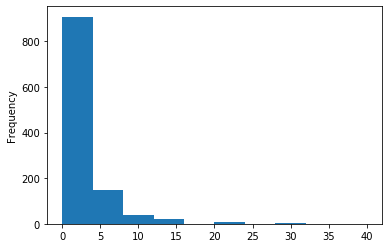

In [5]:
df.numvisit.plot(kind='hist')

In [6]:
df.numvisit.min()

0

In [7]:
np.sum(df.numvisit==0)

360

# Fit the Model

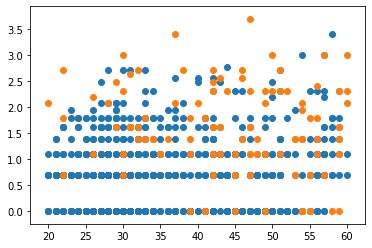

In [8]:
numvisit = df.numvisit.values
age = df.age.values
badh = df.badh.values
plt.scatter(age[(badh==0) & (numvisit>0)], np.log(numvisit[(badh==0) & (numvisit>0)]))
plt.scatter(age[(badh==1) & (numvisit>0)], np.log(numvisit[(badh==1) & (numvisit>0)]))

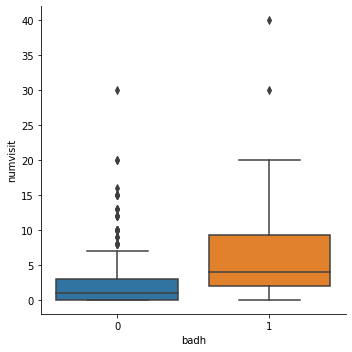

In [9]:
sns.catplot(x='badh', y='numvisit', kind='box', data=df)

In [10]:
from jax import random, lax, nn
import jax.numpy as np

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)
numpyro.enable_validation()

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

$$
P(k \text{ events in interval}) = \frac{\lambda^k}{k!}e^{-\lambda}
$$

In [11]:
def model_fn(numvisit, badh, age):
    int_ = numpyro.sample('int', dist.Normal(0, 1e6))
    b_badh = numpyro.sample('b_badh', dist.Normal(0, 1e4))
    b_age = numpyro.sample('b_age', dist.Normal(0, 1e4))
    b_itx = numpyro.sample('b_itx', dist.Normal(0, 1e4))
    
    # https://www.theanalysisfactor.com/count-models-understanding-the-log-link-function/
    # https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/Lecture27.pdf
    # It is not clear why the log link does not work
    log_lambda = int_ + b_badh*badh + b_age*age + b_itx*age*badh
    lambda_ = np.exp(log_lambda)
    
    numpyro.sample('y', dist.Poisson(lambda_), obs=numvisit)

In [12]:
kernel = NUTS(model_fn)
model = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model.run(rng_key, collect_warmup=False, numvisit=numvisit, badh=badh, age=age)

In [13]:
model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_age     -0.36      0.52      0.01     -1.11      0.01      1.50    315.19
    b_badh      0.82      1.06      1.45     -0.67      1.75      1.52      7.96
     b_itx     -0.18      0.24     -0.01     -0.51     -0.01      1.50     74.88
       int      0.37      0.07      0.40      0.22      0.46      9.54      1.10

Number of divergences: 4939


In [14]:
samples = model.get_samples(group_by_chain=True)
b_age = samples['b_age']
b_badh = samples['b_badh']
b_itx = samples['b_itx']
_int = samples['int']

[[<matplotlib.lines.Line2D at 0x12a4f2278>],

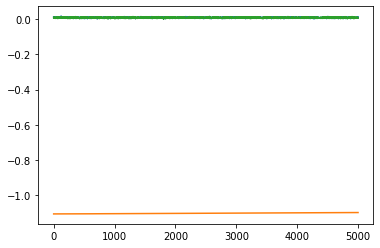

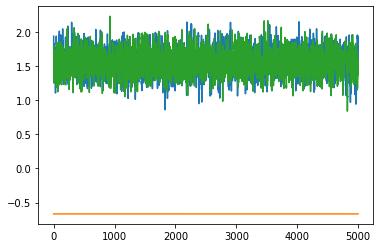

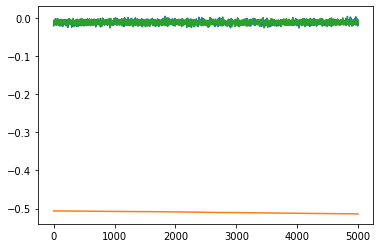

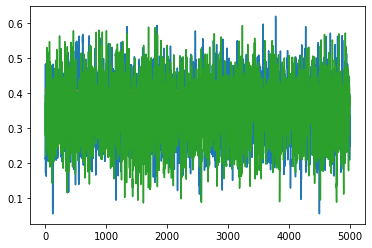

In [15]:
[plt.plot(trace) for trace in b_age]
plt.figure()
[plt.plot(trace) for trace in b_badh]
plt.figure()
[plt.plot(trace) for trace in b_itx]
plt.figure()
[plt.plot(trace) for trace in _int]

## Convergence diag

In [16]:
print(diag.gelman_rubin(b_age))
print(diag.gelman_rubin(b_badh))
print(diag.gelman_rubin(b_itx))
print(diag.gelman_rubin(_int))

292.9004
8.880449
78.935295
1.1220421


In [17]:
lag_idx = [0, 1, 5, 10, 50]
print('age')
for chain in b_age:
    print(("{:.4f}\t"*len(lag_idx)).format(*diag.autocorrelation(chain)[lag_idx]))
print('bad health')
for chain in b_badh:
    print(("{:.4f}\t"*len(lag_idx)).format(*diag.autocorrelation(chain)[lag_idx]))
print('itx')
for chain in b_itx:
    print(("{:.4f}\t"*len(lag_idx)).format(*diag.autocorrelation(chain)[lag_idx]))
print('int')
for chain in _int:
    print(("{:.4f}\t"*len(lag_idx)).format(*diag.autocorrelation(chain)[lag_idx]))    

age
1.0000	0.5087	0.0684	-0.0015	-0.0193	
1.0000	0.9997	0.9983	0.9966	0.9825	
1.0000	0.5037	0.0621	-0.0103	0.0089	
bad health
1.0000	0.5478	0.0784	0.0053	-0.0422	
1.0000	0.9943	0.9726	0.9475	0.7398	
1.0000	0.5859	0.0686	-0.0246	0.0028	
itx
1.0000	0.5540	0.0838	0.0076	-0.0323	
1.0000	0.9997	0.9983	0.9966	0.9825	
1.0000	0.5780	0.0737	-0.0278	-0.0024	
int
1.0000	0.5319	0.0727	0.0041	-0.0230	
1.0000	0.9980	0.9902	0.9802	0.9084	
1.0000	0.5201	0.0614	-0.0133	0.0106	


## DIC

In [18]:
def dic(model_fn, samples, **kwargs):
    pi_theta = numpyro.infer.log_likelihood(model_fn, samples, **kwargs)['y'].sum(axis=1)
    D_bar = -2 * pi_theta.mean(axis=0)
    theta_star = {k: v.mean(axis=0, keepdims=True) for k, v in samples.items()}
    pi_theta_star = numpyro.infer.log_likelihood(model_fn, theta_star, **kwargs)['y'].sum()
    D_theta_star = -2 * pi_theta_star
    print('expected deviance:', D_bar)
    print('effective number of parameters:', D_bar - D_theta_star)
    print('DIC:', D_bar - D_theta_star + D_bar)

In [19]:
samples = model.get_samples(group_by_chain=False)
dic(model_fn, samples, numvisit=numvisit, badh=badh, age=age)

expected deviance: nan
effective number of parameters: nan
DIC: nan


## Residuals

In [20]:
X = df.values[:, 1:]

In [21]:
X = np.hstack([X, X.prod(axis=1, keepdims=True)])

In [22]:
X[:5]

DeviceArray([[ 0, 58,  0],
             [ 0, 54,  0],
             [ 0, 44,  0],
             [ 0, 57,  0],
             [ 0, 33,  0]], dtype=int32)

In [23]:
X[-5:]

DeviceArray([[ 1, 44, 44],
             [ 1, 46, 46],
             [ 1, 46, 46],
             [ 1, 60, 60],
             [ 1, 50, 50]], dtype=int32)

In [24]:
W = np.vstack([samples['b_badh'], samples['b_age'], samples['b_itx']])
_int = samples['int']
W_median = np.median(W, axis=1, keepdims=True)
_int_median = np.median(_int)

In [25]:
# lam_hat = np.exp(X @ W + _int_median).squeeze()
lam_hat = np.exp(X @ W_median + _int_median).squeeze()

In [26]:
resid = df.numvisit.values - lam_hat

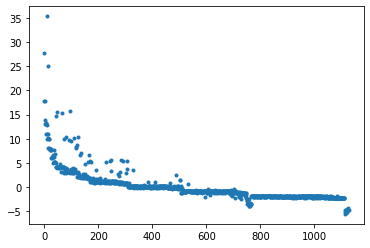

In [27]:
plt.plot(resid, '.')

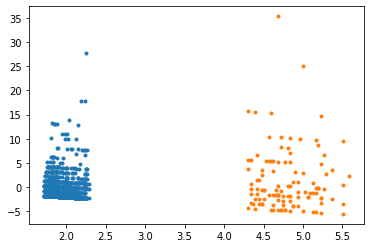

In [28]:
plt.plot(lam_hat[badh==0], resid[badh==0], '.')
plt.plot(lam_hat[badh==1], resid[badh==1], '.')

In [29]:
x1 = np.array([[0, 35, 0]])
x2 = np.array([[1, 35, 35]])

In [30]:
lam1 = np.exp(x1 @ W + _int).squeeze()

In [31]:
lam2 = np.exp(x2 @ W + _int).squeeze()

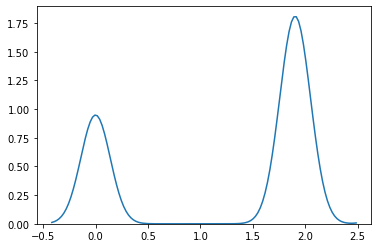

In [32]:
sns.distplot(lam1, hist=False)
# sns.distplot(lam2, hist=False)

In [33]:
y1 = numpyro.sample('y1', dist.Poisson(lam1), rng_key=rng_key)
y2 = numpyro.sample('y2', dist.Poisson(lam2), rng_key=rng_key)

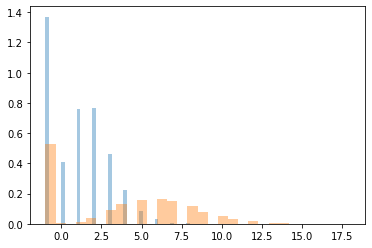

In [34]:
sns.distplot(y1, kde=False, norm_hist=True)
sns.distplot(y2, kde=False, norm_hist=True)

In [35]:
np.mean(y2 > y1)

DeviceArray(0.65653336, dtype=float32)

In [36]:
val1, count1 = onp.unique(y1, return_counts=True)
val2, count2 = onp.unique(y2, return_counts=True)

<BarContainer object of 20 artists>

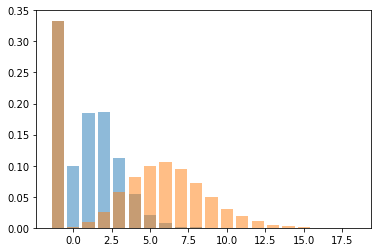

In [37]:
plt.bar(val1, count1/count1.sum(), alpha=.5)
plt.bar(val2, count2/count2.sum(), alpha=.5)